In [53]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

%matplotlib inline

In [3]:
ads_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-sedelkin/practice/data/miniproject_6/ads_data.csv', parse_dates=['date', 'time'])
ads_clients_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-sedelkin/practice/data/miniproject_6/ads_clients_data.csv', parse_dates=['date', 'create_date'])

In [4]:
ads_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


In [5]:
ads_data.dtypes

date                     datetime64[ns]
time                     datetime64[ns]
event                            object
platform                         object
ad_id                             int64
client_union_id                   int64
campaign_union_id                 int64
ad_cost_type                     object
ad_cost                         float64
has_video                         int64
target_audience_count             int64
dtype: object

In [6]:
ads_clients_data.head()

,date,client_union_id,community_id,create_date
0,2020-05-07,1,-130371893,2018-12-24
1,2020-05-07,2,-130304626,2019-02-10
2,2020-05-07,3,-130462599,2019-01-25
3,2020-05-07,4,-130574300,2018-12-09
4,2020-05-07,5,-130292358,2019-01-08


In [7]:
# Calculate mean number of clicks and views per ad_id

events_by_ad_id = ads_data \
    .groupby(['ad_id', 'event'], as_index=False) \
    .agg({'date': 'count'}) \
    .pivot(index='ad_id', columns='event', values='date') \
    .fillna(0)

events_by_ad_id

print('Clicks count mean is: {}'.format(events_by_ad_id.click.mean().round(0)))
print('Views count mean is: {}'.format (events_by_ad_id.view.mean().round(0)))

Clicks count mean is: 113.0
Views count mean is: 923.0


In [8]:
# Calculate logarithm of views number, dropping zeros since log(0)=infinity, draw a histogram of the distribution

events_by_ad_id['view_log'] = np.log(events_by_ad_id[events_by_ad_id['view'] != 0].view)

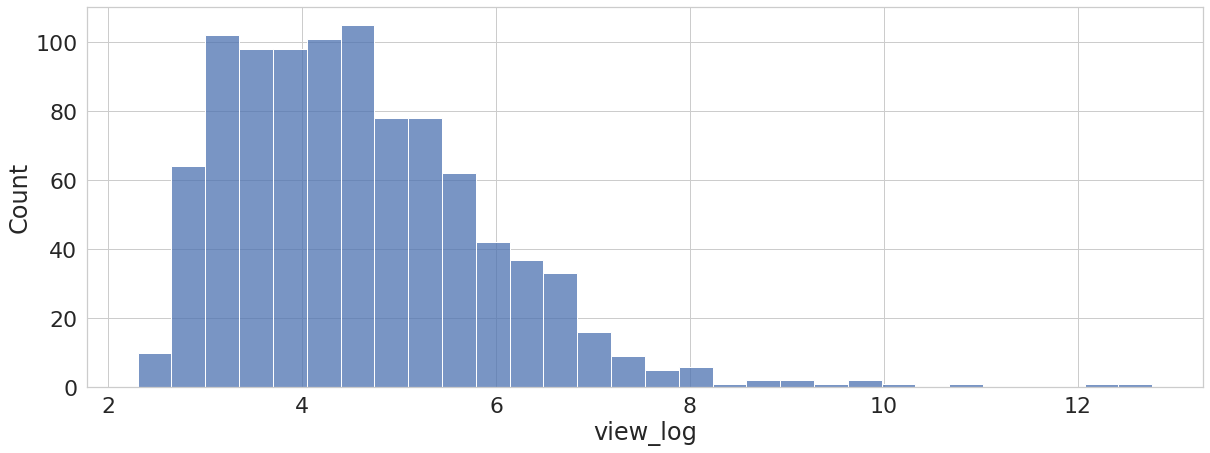

In [9]:
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )
sns.histplot(events_by_ad_id['view_log'])

In [10]:
# Теперь нужно найти среднее количество показов на 1 объявление (ad_id) по дням, 
# не учитывая объявления, у которых не было показов (обычное среднее). 
# После этого посчитайте скользящее среднее по полученному результату с окном в 2 элемента.

# Вопрос: Какое значение скользящего среднего получим за 6 апреля 2019 года? Округлите ответ до целого числа.

views_by_date = ads_data[ads_data.event == 'view'] \
    .groupby(['ad_id', 'date'], as_index=False) \
    .agg({'event': 'count'}) \
    .pivot(index='ad_id', columns='date', values='event')


In [11]:
# Compare mean and rolling mean

views_by_date_rolling_mean = pd.DataFrame(views_by_date.mean().rolling(2).mean().round())
views_by_date_mean = pd.DataFrame(views_by_date.mean())
views_by_date_rolling_mean

,0
date,
2019-04-01,NaN
2019-04-02,146.0
2019-04-03,151.0
2019-04-04,420.0
2019-04-05,798.0
2019-04-06,598.0


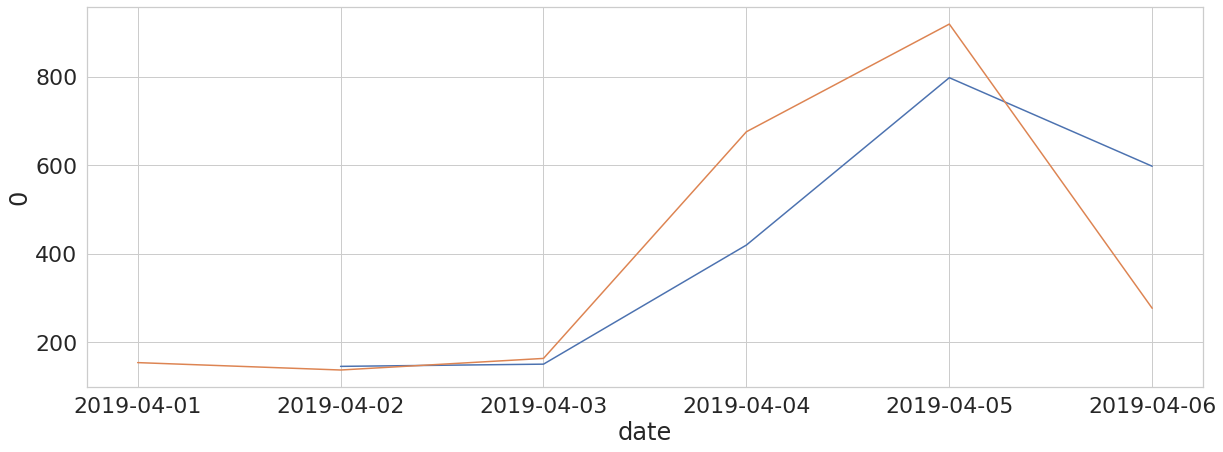

In [12]:
sns.lineplot(data=views_by_date_rolling_mean, x='date', y=0)
sns.lineplot(data=views_by_date_mean, x='date', y=0)

In [13]:
# Объедините данные рекламы с данными о рекламных клиентах и найдите среднее количество дней 
# от даты создания рекламного клиента (create_date) 
# и первым запуском рекламного объявления этим клиентом (date).

ads_data_union_clients = ads_data.merge(ads_clients_data[['community_id', 'create_date', 'client_union_id']], on='client_union_id')

In [20]:
ads_data_union_clients['days_till_ad'] = ads_data_union_clients.date - ads_data_union_clients.create_date

first_ads = ads_data_union_clients.groupby('client_union_id').agg({'days_till_ad': 'min'})
first_ads.days_till_ad.mean()

Timedelta('124 days 09:04:43.532219570')

In [30]:
# Давайте вычислим конверсию из создания рекламного кабинета в запуск первой рекламы в течение не более 365 дней.
# Чтобы отобрать данные за нужный промежуток, можно воспользоваться сравнением времени до создания первой рекламы 
# с pd.Timedelta(365, unit='day')

year = pd.Timedelta(365, unit='day')

yearly_conversion = ((first_ads[first_ads.days_till_ad < year].count() / ads_clients_data.client_union_id.nunique()) * 100).round(2)

yearly_conversion

days_till_ad    0.69
dtype: float64

In [21]:
first_ads.head()

,days_till_ad
client_union_id,
1,98 days
9,114 days
13,66 days
16,105 days
20,32 days


In [31]:
# Давайте разобъем наших клиентов по промежуткам от создания рекламного кабинета до запуска 
# первого рекламного объявления.
# Определите, сколько уникальных клиентов запустили свое первое объявление 
# в первый месяц своего существования (от 0 до 30 дней). 
# Список промежутков дней для метода pd.cut() – [0, 30, 90, 180, 365]. 

converted_within_year = first_ads[first_ads.days_till_ad < year]

In [40]:
intervals = [0, 30, 90, 180, 365]
time_intervals = []
for i in intervals:
    time_intervals.append(pd.Timedelta(i, unit='day'))

interval_labels 

In [85]:
clients_cut = pd.DataFrame(pd.cut(converted_within_year.days_till_ad, time_intervals, labels=intervals[1:]))
client_cohorts = pd.DataFrame(clients_cut.days_till_ad \
                                  .value_counts() \
                                  .reset_index() \
                                  .rename(columns={'index': 'cohort', 'days_till_ad': 'client_count'}))

In [86]:
fig = px.bar(client_cohorts, x='cohort', y='client_count')
fig.show()